<b>Breast Cancer Wisconsin (Diagnostic) Data Set</b> 
(reference to UCI Machine Learning Repository <a href="http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29">description</a>)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

import seaborn as sns
sns.set()

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

from lib.utils import *
from lib.outlierdetection import *

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 92%


In [2]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "SEED"                : 0
})

In [3]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  

In [4]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
feature_names = dataset.feature_names
target_names = dataset.target_names
data = pd.DataFrame(np.c_[dataset['target'], dataset['data']], columns= np.append(['diagnosis'], feature_names ))

X = np.float32(data.drop('diagnosis', axis=1).values)
y = np.int64(data['diagnosis'].values)   # conversion to int64 for pytorch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       30
number of classes:        2
data type:                float32
number of train samples:  381 (pos=236, neg=145, size=0MB)
number of test samples:   188 (pos=121, neg=67, size=0MB)
labels                    ['malignant' 'benign']


In [5]:
from sklearn.svm import SVC
params = {
    'C': 1, 
    'kernel': 'linear'}

pipeline = Pipeline(steps=[
              ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('outlier',    OutlierSampler(8.5)),  # see data analysis for source of 8.5
              ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
              ('classifier', SVC(**params))
])

scoring = 'f1'

pipeline, params

(Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('outlier', OutlierSampler(memory=None, threshold=8.5, verbose=0)), ('sampler', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
    out_step=0.5, random_state=0, ratio='auto', svm_estimator=Non...,
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False))]), {'C': 1, 'kernel': 'linear'})

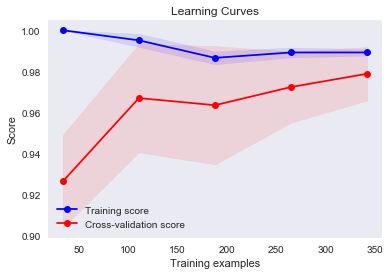

In [6]:
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
_ = plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, 
                        cv=cv, scoring=scoring, shuffle=True, random_state=HP.SEED)

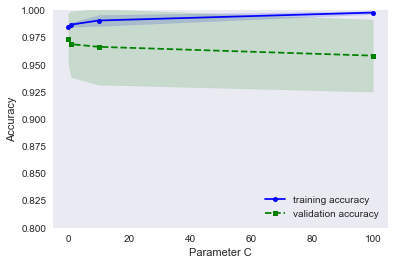

In [7]:
from sklearn.model_selection import validation_curve

param_range = [ 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipeline,
                 X=X_train,
                 y=y_train,
                 param_name='classifier__C',
                 param_range=param_range,
                 cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(param_range, train_mean,
          color='blue', marker='o',
          markersize=5,
          label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                  train_mean - train_std, alpha=0.15,
                  color='blue')
plt.plot(param_range, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='validation accuracy')
plt.fill_between(param_range,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
#plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

Trainings score: 0.9885347996593621 0.002200576631197809
Validation score: 0.9833352093913857 0.01536880821342549


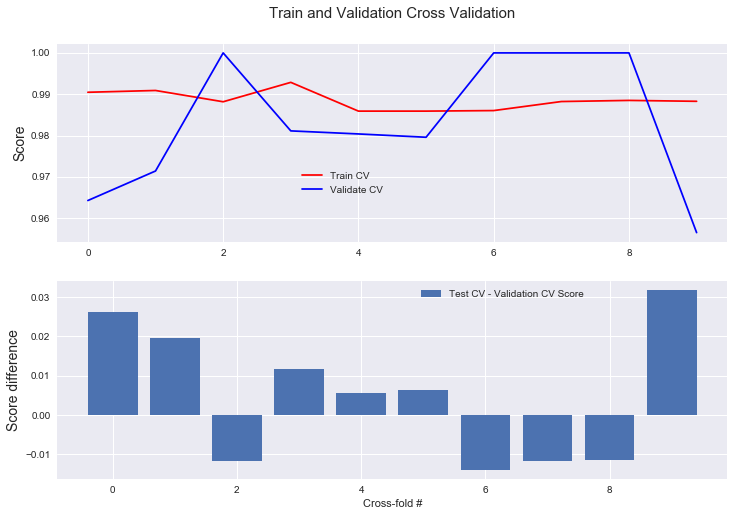

In [8]:
# Cross-validate to train best model 

cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True, 
                        verbose=0, n_jobs=-1)

print("Trainings score:", np.mean(scores['train_score']), np.std(scores['train_score']))
print("Validation score:", np.mean(scores['test_score']), np.std(scores['test_score']))
plot_cross_validation_scores(scores, figsize=(12, 8))

In [10]:
# http://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md\

y_pred = pipeline.fit(X_train, y_train).predict(X_test)
# y_prob = pipeline.predict_proba(X_test)

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))              # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[ 65   2]
 [  6 115]]
Accuracy  0.9574468085106383
Recall    0.9504132231404959
Precision 0.9829059829059829
F1        0.9663865546218487
ROC AUC   0.9602812384359196


In [11]:
#  Cross-validate score on testset
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv,  scoring="accuracy",  verbose=0, n_jobs=-1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.973391812865497 0.0355344370184721


In [13]:
# plot_roc_curve(y_test, y_pred, y_prob)

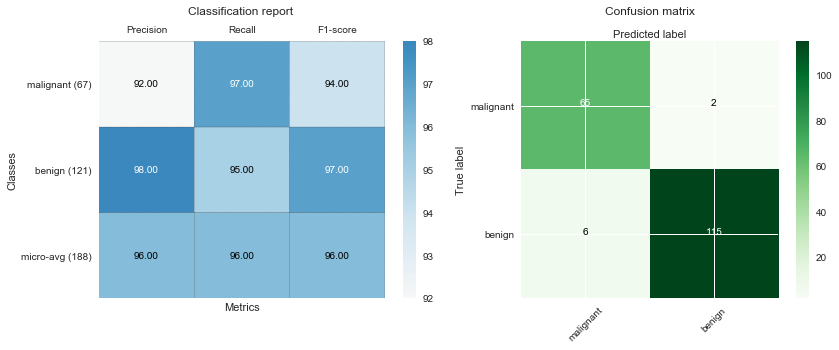

In [14]:
plot_classifier_summary(y_test, y_pred, target_names)

In [17]:
# plot_scatter_plots(X_test, y_pred, y_prob, y_test, target_names, figsize=(18,6))

In [18]:
# Check classification of full data set
classifier_summary_report(X, y, pipeline.predict(X), target_names)

Note: weighted average f1-score 
              precision    recall  f1-score   support

  malignant       0.97      0.97      0.97       212
     benign       0.98      0.98      0.98       357

avg / total       0.98      0.98      0.98       569



'Data points=569'

'Features=30'

'Class dist.=0.627417'

'F1 valid=0.981767'

'ACC=0.977153'

'ROC_AUC=0.976045'

'LOG_LOSS=0.789119'

'Misclassified=13'

'Data points=[40, 68, 73, 135, 152, 157, 190, 213, 225, 297, 340, 413, 542]'